In [2]:
import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import setup, compare_models, predict_model, finalize_model

In [3]:
file_paths = ['19A.npy', 'BT2.npy', 'F1B.npy', 'SR.npy']
data = {file_path.split('/')[-1].split('.')[0]: np.load(file_path) for file_path in file_paths}

data_prepared = {key: pd.DataFrame(data=value, columns=[f'feature_{i}' for i in range(value.shape[1] - 1)] + ['Vp']) for key, value in data.items()}
combinations_list = list(combinations(data_prepared.keys(), 3))

In [8]:
def plot_depth_predictions(depth, y_actual, y_predicted, title):
    ztop = np.min(depth) - 2.0
    zbot = np.max(depth)
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_actual, depth, '-', label='Measured', color='black')
    plt.plot(y_predicted, depth, '-', label='Predicted', color='r')
    plt.legend()
    plt.ylim(ztop, zbot)
    plt.gca().invert_yaxis()
    plt.xlabel("$V_p$ (Km/s)")
    plt.ylabel("Depth (m)")
    plt.title(title)
    plt.locator_params(axis='x', nbins=5)
    plt.xlim(1.5, 6)
    plt.grid(True)
    plt.show()


,Description,Value
0,Session id,123
1,Target,Vp
2,Target type,Regression
3,Original data shape,"(5987, 10)"
4,Transformed data shape,"(5987, 10)"
5,Transformed train set shape,"(4190, 10)"
6,Transformed test set shape,"(1797, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0008,0.0000,0.0038,0.9992,0.0011,0.0003,0.1320
rf,Random Forest Regressor,0.0009,0.0000,0.0044,0.9987,0.0013,0.0004,0.3400
gbr,Gradient Boosting Regressor,0.0021,0.0000,0.0051,0.9987,0.0015,0.0009,0.1650
lightgbm,Light Gradient Boosting Machine,0.0015,0.0000,0.0049,0.9986,0.0014,0.0006,0.0750
dt,Decision Tree Regressor,0.0011,0.0000,0.0051,0.9984,0.0014,0.0005,0.0090
lr,Linear Regression,0.0023,0.0001,0.0077,0.9966,0.0022,0.0009,0.0060
br,Bayesian Ridge,0.0023,0.0001,0.0077,0.9966,0.0022,0.0009,0.0060
ridge,Ridge Regression,0.0082,0.0002,0.0123,0.9925,0.0036,0.0034,0.0060
ada,AdaBoost Regressor,0.0146,0.0004,0.0188,0.9826,0.0057,0.0063,0.0510
knn,K Neighbors Regressor,0.0270,0.0018,0.0424,0.9109,0.0124,0.0111,0.0080


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0168,0.0003,0.0185,0.9760,0.0053,0.0068


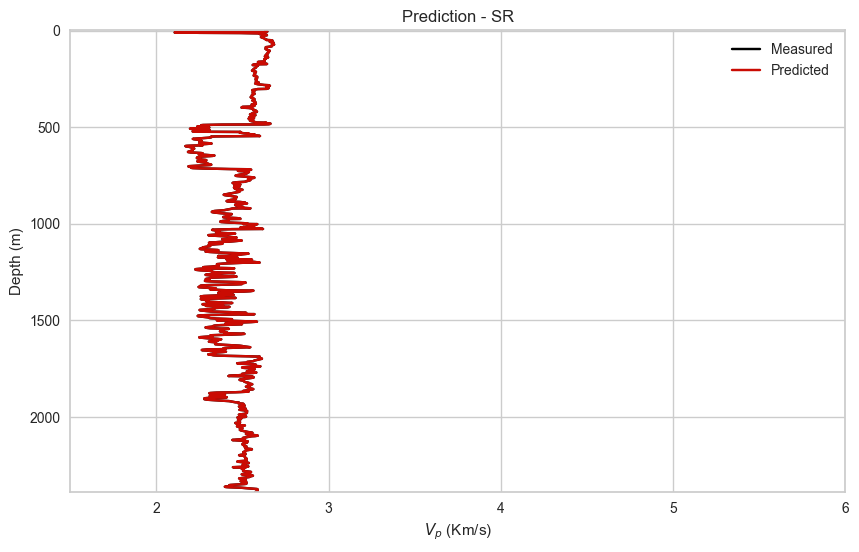

,Description,Value
0,Session id,123
1,Target,Vp
2,Target type,Regression
3,Original data shape,"(3447, 10)"
4,Transformed data shape,"(3447, 10)"
5,Transformed train set shape,"(2412, 10)"
6,Transformed test set shape,"(1035, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0018,0.0000,0.0060,0.9976,0.0017,0.0008,0.1000
rf,Random Forest Regressor,0.0026,0.0001,0.0074,0.9964,0.0021,0.0011,0.2520
lightgbm,Light Gradient Boosting Machine,0.0033,0.0001,0.0077,0.9961,0.0022,0.0014,0.0900
gbr,Gradient Boosting Regressor,0.0041,0.0001,0.0078,0.9960,0.0023,0.0017,0.1170
dt,Decision Tree Regressor,0.0031,0.0001,0.0093,0.9942,0.0027,0.0013,0.0080
lr,Linear Regression,0.0092,0.0003,0.0167,0.9822,0.0048,0.0038,0.0050
br,Bayesian Ridge,0.0092,0.0003,0.0167,0.9822,0.0048,0.0038,0.0060
ada,AdaBoost Regressor,0.0150,0.0004,0.0201,0.9745,0.0060,0.0063,0.0300
ridge,Ridge Regression,0.0170,0.0006,0.0241,0.9634,0.0069,0.0070,0.0050
knn,K Neighbors Regressor,0.0236,0.0014,0.0378,0.9091,0.0110,0.0097,0.0080


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0061,0.0002,0.0148,0.9901,0.0046,0.0028


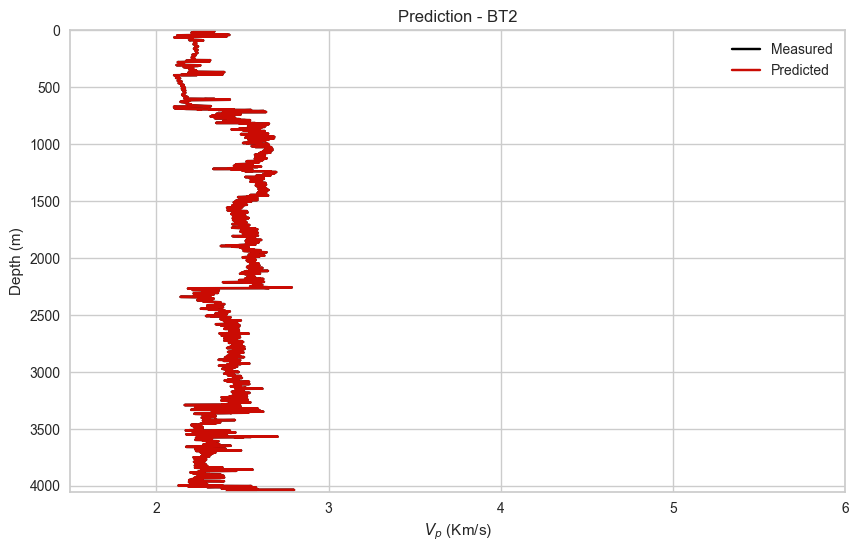

,Description,Value
0,Session id,123
1,Target,Vp
2,Target type,Regression
3,Original data shape,"(4320, 10)"
4,Transformed data shape,"(4320, 10)"
5,Transformed train set shape,"(3024, 10)"
6,Transformed test set shape,"(1296, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0010,0.0000,0.0030,0.9993,0.0009,0.0004,0.1120
rf,Random Forest Regressor,0.0014,0.0000,0.0041,0.9988,0.0012,0.0006,0.2950
lightgbm,Light Gradient Boosting Machine,0.0019,0.0000,0.0042,0.9988,0.0012,0.0008,0.0760
gbr,Gradient Boosting Regressor,0.0028,0.0000,0.0046,0.9986,0.0013,0.0011,0.1390
dt,Decision Tree Regressor,0.0017,0.0000,0.0051,0.9982,0.0014,0.0007,0.0090
lr,Linear Regression,0.0041,0.0000,0.0070,0.9969,0.0020,0.0017,0.0070
br,Bayesian Ridge,0.0041,0.0000,0.0070,0.9969,0.0020,0.0017,0.0070
ridge,Ridge Regression,0.0109,0.0002,0.0144,0.9872,0.0041,0.0044,0.0060
ada,AdaBoost Regressor,0.0161,0.0004,0.0196,0.9760,0.0059,0.0068,0.0460
knn,K Neighbors Regressor,0.0209,0.0012,0.0352,0.9225,0.0103,0.0086,0.0090


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0050,0.0001,0.0106,0.9949,0.0033,0.0022


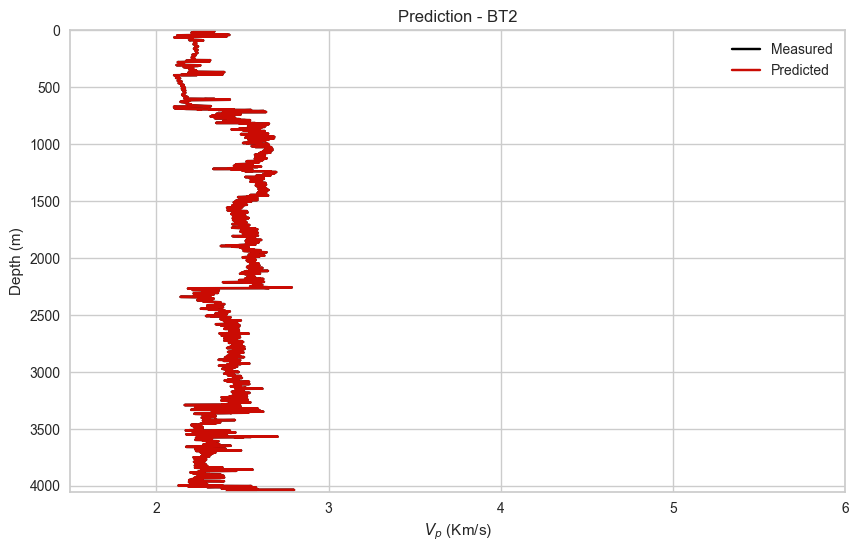

,Description,Value
0,Session id,123
1,Target,Vp
2,Target type,Regression
3,Original data shape,"(5574, 10)"
4,Transformed data shape,"(5574, 10)"
5,Transformed train set shape,"(3901, 10)"
6,Transformed test set shape,"(1673, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0015,0.0000,0.0053,0.9985,0.0015,0.0006,0.1360
rf,Random Forest Regressor,0.0017,0.0000,0.0061,0.9980,0.0018,0.0007,0.3590
gbr,Gradient Boosting Regressor,0.0034,0.0001,0.0073,0.9973,0.0021,0.0014,0.1900
lightgbm,Light Gradient Boosting Machine,0.0026,0.0001,0.0073,0.9972,0.0021,0.0011,0.1050
dt,Decision Tree Regressor,0.0020,0.0001,0.0073,0.9972,0.0021,0.0008,0.0090
lr,Linear Regression,0.0064,0.0002,0.0149,0.9885,0.0043,0.0026,0.0050
br,Bayesian Ridge,0.0064,0.0002,0.0149,0.9885,0.0043,0.0026,0.0060
lar,Least Angle Regression,0.0069,0.0002,0.0151,0.9882,0.0043,0.0028,0.0060
ridge,Ridge Regression,0.0115,0.0003,0.0185,0.9829,0.0053,0.0047,0.0050
ada,AdaBoost Regressor,0.0165,0.0004,0.0211,0.9780,0.0063,0.0070,0.0530


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0044,0.0001,0.0094,0.9946,0.0029,0.0019


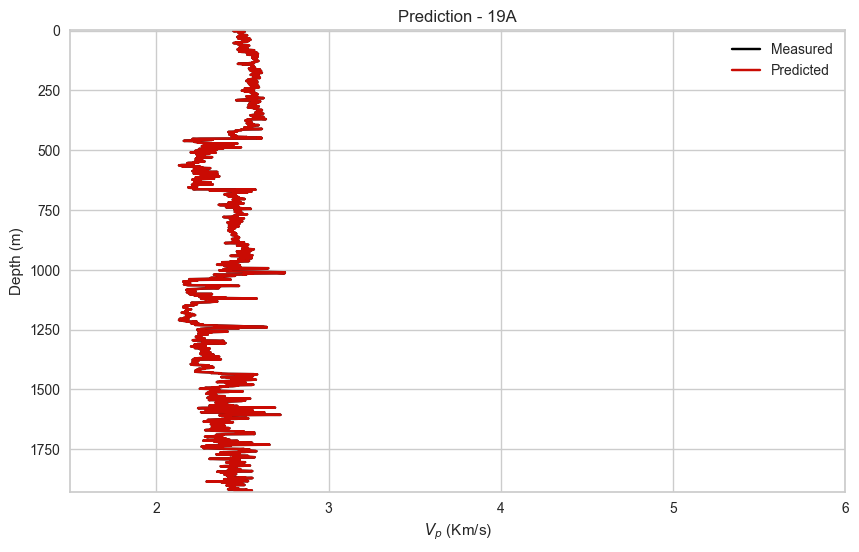

,Description,Value
0,Session id,123
1,Target,Vp
2,Target type,Regression
3,Original data shape,"(6447, 10)"
4,Transformed data shape,"(6447, 10)"
5,Transformed train set shape,"(4512, 10)"
6,Transformed test set shape,"(1935, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0010,0.0000,0.0033,0.9994,0.0010,0.0004,0.1510
rf,Random Forest Regressor,0.0011,0.0000,0.0040,0.9991,0.0011,0.0005,0.4400
gbr,Gradient Boosting Regressor,0.0025,0.0000,0.0045,0.9989,0.0013,0.0010,0.2000
lightgbm,Light Gradient Boosting Machine,0.0018,0.0000,0.0045,0.9988,0.0013,0.0007,0.0790
dt,Decision Tree Regressor,0.0013,0.0000,0.0047,0.9986,0.0014,0.0005,0.0110
lr,Linear Regression,0.0048,0.0001,0.0087,0.9958,0.0026,0.0020,0.0070
br,Bayesian Ridge,0.0048,0.0001,0.0087,0.9958,0.0026,0.0020,0.0110
ridge,Ridge Regression,0.0087,0.0002,0.0126,0.9919,0.0037,0.0035,0.0070
ada,AdaBoost Regressor,0.0130,0.0003,0.0165,0.9863,0.0049,0.0055,0.0580
knn,K Neighbors Regressor,0.0191,0.0011,0.0322,0.9467,0.0094,0.0079,0.0090


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0033,0.0001,0.0082,0.9959,0.0025,0.0014


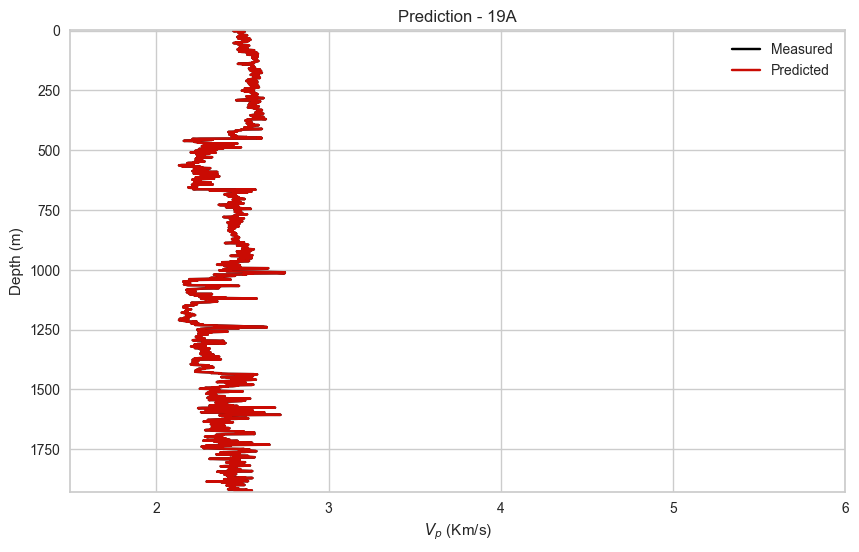

,Description,Value
0,Session id,123
1,Target,Vp
2,Target type,Regression
3,Original data shape,"(3907, 10)"
4,Transformed data shape,"(3907, 10)"
5,Transformed train set shape,"(2734, 10)"
6,Transformed test set shape,"(1173, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0020,0.0000,0.0056,0.9977,0.0016,0.0008,0.1160
rf,Random Forest Regressor,0.0026,0.0000,0.0068,0.9967,0.0020,0.0011,0.3040
lightgbm,Light Gradient Boosting Machine,0.0031,0.0000,0.0068,0.9967,0.0020,0.0013,0.0950
gbr,Gradient Boosting Regressor,0.0044,0.0001,0.0078,0.9959,0.0022,0.0018,0.1360
dt,Decision Tree Regressor,0.0033,0.0001,0.0093,0.9940,0.0027,0.0014,0.0080
lr,Linear Regression,0.0093,0.0003,0.0164,0.9817,0.0047,0.0038,0.0060
br,Bayesian Ridge,0.0093,0.0003,0.0164,0.9817,0.0047,0.0038,0.0060
ada,AdaBoost Regressor,0.0197,0.0005,0.0224,0.9664,0.0066,0.0081,0.0420
ridge,Ridge Regression,0.0153,0.0005,0.0228,0.9650,0.0065,0.0062,0.0070
knn,K Neighbors Regressor,0.0158,0.0008,0.0282,0.9448,0.0083,0.0065,0.0080


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0101,0.0002,0.0130,0.9897,0.0038,0.0042


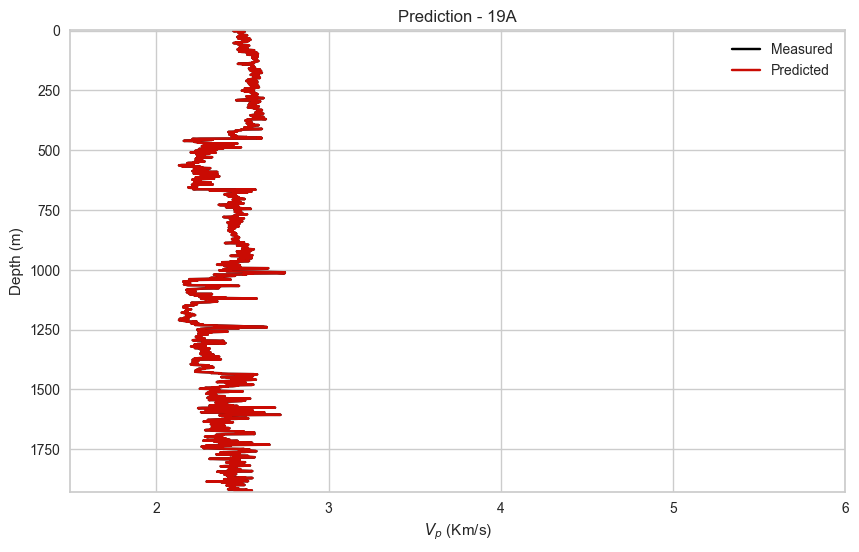

In [9]:
for combination in combinations_list:
    train_data = pd.concat([data_prepared[key].reset_index(drop=True) for key in combination], axis=0, ignore_index=True)
    test_data_key = list(set(data_prepared.keys()) - set(combination))[0]
    test_data = data_prepared[test_data_key]

    # Initialize PyCaret
    exp = setup(data=train_data, target='Vp', session_id=123)

    # Compare and create a model
    best_model = compare_models()

    # Train the best model
    trained_model = finalize_model(best_model)

    # Make predictions on the test data
    predictions = predict_model(trained_model, data=test_data)

    # Print the columns of the predictions DataFrame
    st.write("Predictions Columns:", predictions.columns)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(predictions['Vp'], test_data['Vp']))
    r2 = r2_score(predictions['Vp'], test_data['Vp'])

    # Print or log the results
    st.write(f"Combination: {combination}, Test Well: {test_data_key}")
    st.write(f"RMSE: {rmse}")
    st.write(f"R-squared: {r2}")

    # Plot predictions
    plot_depth_predictions(test_data.index, test_data['Vp'], predictions['Vp'], f"Prediction - {test_data_key}")